In [34]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath

import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

import SimpleTemp
from SimpleTemp import _temperature_scaling
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
import plotter
from plotter import plotter
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

from scipy.optimize import minimize_scalar
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


In [3]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [4]:
logpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.dev_preds")


In [5]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=20)
    return prob_true, prob_pred


In [6]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [7]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

In [9]:
with open(logpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [10]:
testpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)

Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [13]:
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

In [14]:
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

In [15]:
p_dev = mp1
y_dev = np.array(M1['golds'],dtype = int)

In [23]:
np.max(logits)

0.6182268557394557

In [30]:
def temperature_scaling(logits, y):
    def temperature_obj(t):
        temp_logits = logits / (t + .00000001)
        return log_loss(y, temp_logits)
    
    res = minimize_scalar(temperature_obj)
    return logits / res.x

In [ ]:
import matplotlib.pyplot as plt


In [36]:
# Get logits for the test set
#logits = p_dev#1/(1+ np.exp(-p_dev))
logits = np.exp(p_dev) / (1 + np.exp(p_dev))


# Calibrate using Temperature Scaling
logits_temp_scaled = temperature_scaling(logits, y_dev)
y_pred_probs_temp_scaled = np.exp(logits_temp_scaled) / (1 + np.exp(logits_temp_scaled))

In [37]:
y_pred_probs_temp_scaled

array([0.50847294, 0.50797552, 0.50782332, ..., 0.50769698, 0.5079735 ,
       0.5081625 ])

(array([2401., 2731., 2642., 2561., 2198., 1764., 1063.,  497.,  160.,
          12.]),
 array([0.50754021, 0.50771112, 0.50788202, 0.50805293, 0.50822384,
        0.50839474, 0.50856565, 0.50873656, 0.50890746, 0.50907837,
        0.50924928]),
 <BarContainer object of 10 artists>)

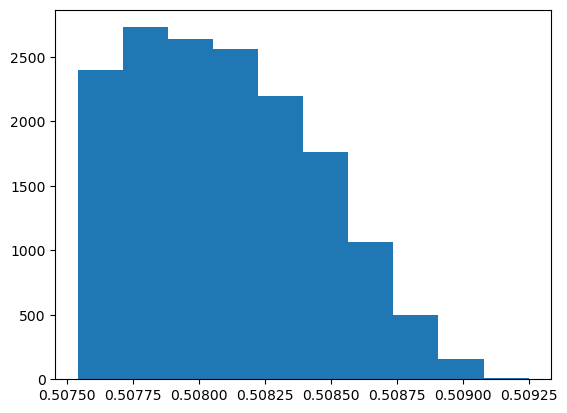

In [38]:
plt.hist(y_pred_probs_temp_scaled)

In [ ]:
#https://medium.com/@eskandar.sahel/applying-calibration-techniques-to-improve-probabilistic-predictions-in-machine-learning-models-c175c2e38ffc

In [255]:
cal1 =platt (mp1,  np.array(M1['golds'],dtype = int),  M_test1['probs'] )
cal2 =platt (mp2,  np.array(M2['golds'],dtype = int),  M_test2['probs']  )
cal3 =platt (mp3, np.array(M3['golds'],dtype = int),   M_test3['probs']  )
cal4 =platt (mp4, np.array(M4['golds'],dtype = int),  M_test4['probs']  )
cal0 =platt (np.array(M['probs']), np.array(M ['golds'],dtype = int),  M_test ['probs']  )

In [203]:
def get_cal (M_i, M_i_test):
    platt = PlattCalibrator(log_odds = False)
    y = np.array(M_i['golds'],dtype = int)
    x = M_i['probs'].to_numpy()
    platt.fit(x, y)
    cal = platt.predict(M_i_test['probs'])
    return cal

In [204]:
y_prob = np.array(M1['probs'])
y_true = np.array(M1['golds'],dtype = int)
p_test = M_test1['probs']

In [206]:
def get_coef (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    intercept_ = logistic.intercept_
    fit = p_test * coef_[0] + intercept_
    return  coef_ , intercept_

In [207]:
get_coef(np.array(M['probs']), np.array(M ['golds'],dtype = int),  M_test ['probs']  )

(array([7.70237714]), array([-4.9738088]))

In [213]:
get_coef(np.array(M1['probs']), np.array(M1 ['golds'],dtype = int),  M_test1 ['probs']  )

(array([5.63015157]), array([-4.46723139]))

In [247]:
def platt_global (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    intercept_ = logistic.intercept_
    fit = p_test * coef_[0]  + 4.973
    out = 1 / (1 + np.exp(fit))
    return  out

In [ ]:
y1, p1 = compute_calibration_curve(M_test1['golds'], cal1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal4 )


In [267]:
y1, p1 = compute_calibration_curve(M_test1['golds'], tp1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], tp2)
y3, p3 = compute_calibration_curve(M_test3['golds'], tp3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], tp4 )


In [257]:
y0, p0 = compute_calibration_curve(M_test['golds'], cal0 )


In [268]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

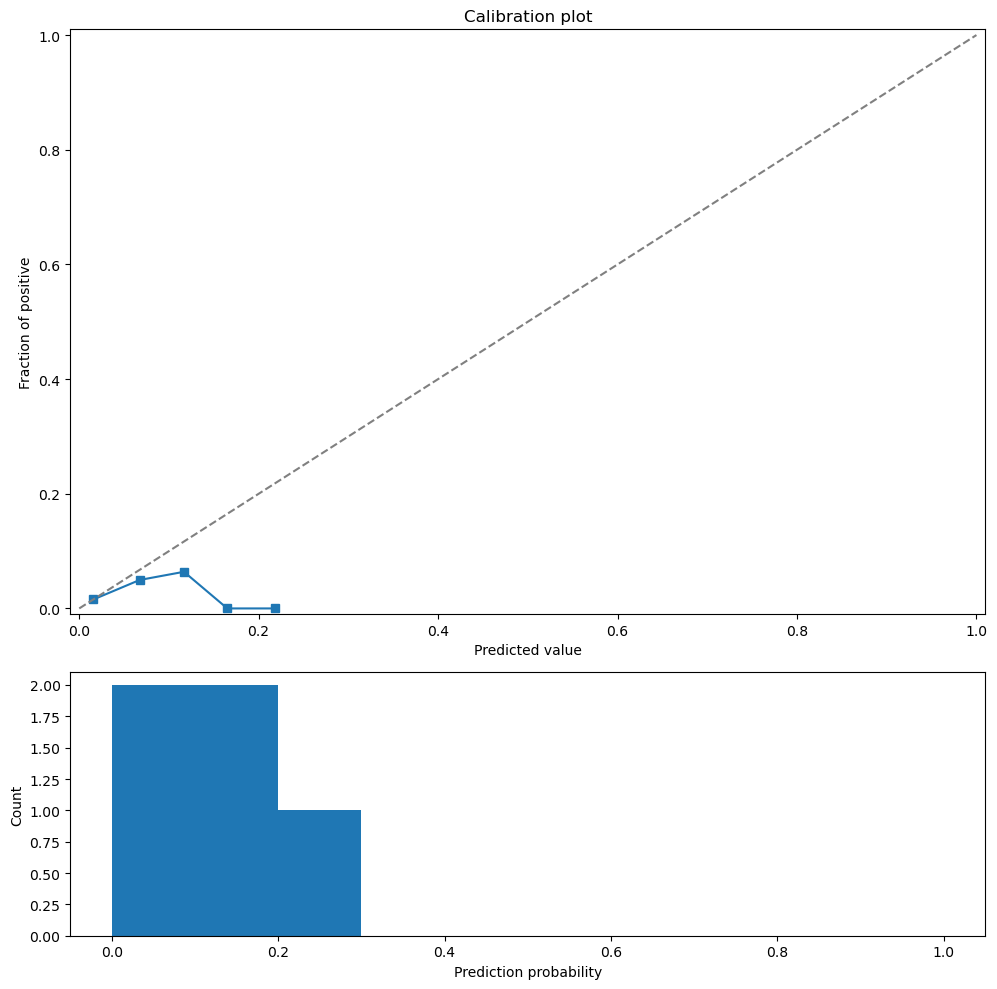

In [269]:
plotter(p0, y0)

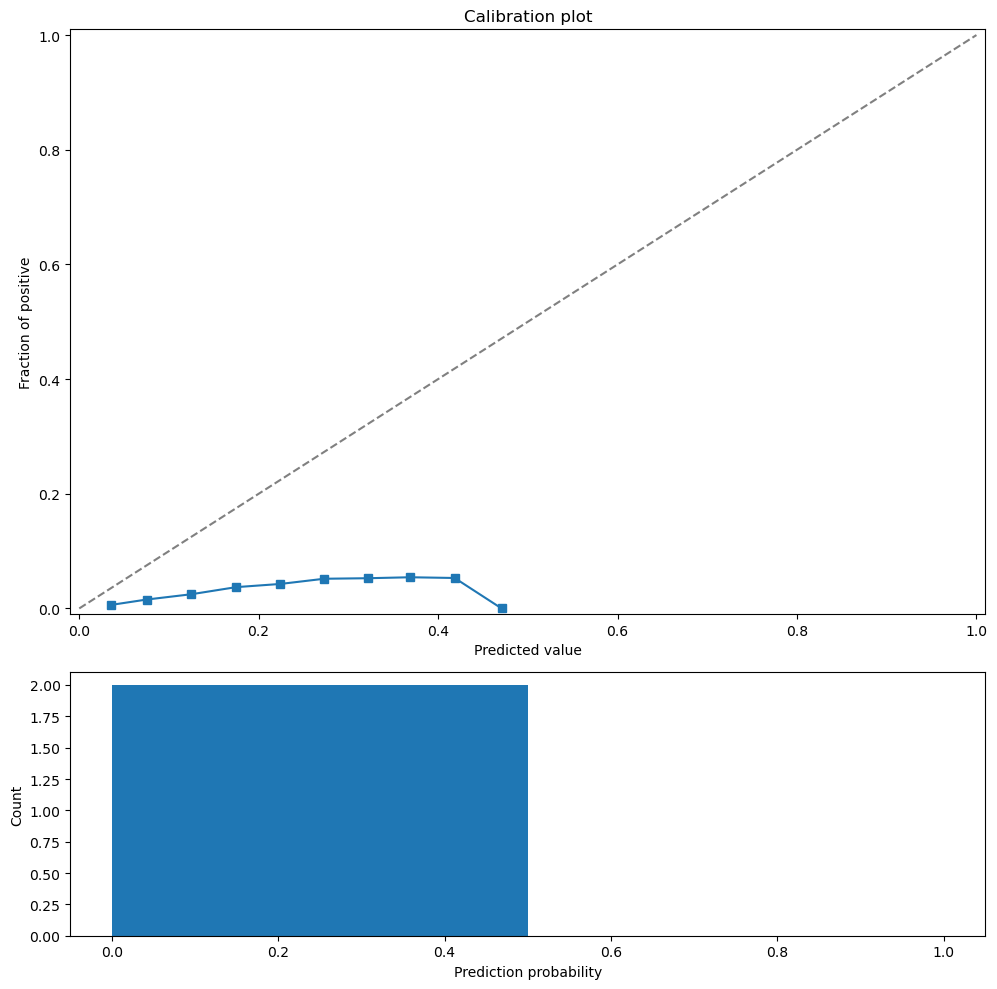

In [270]:
plotter(p1, y1)

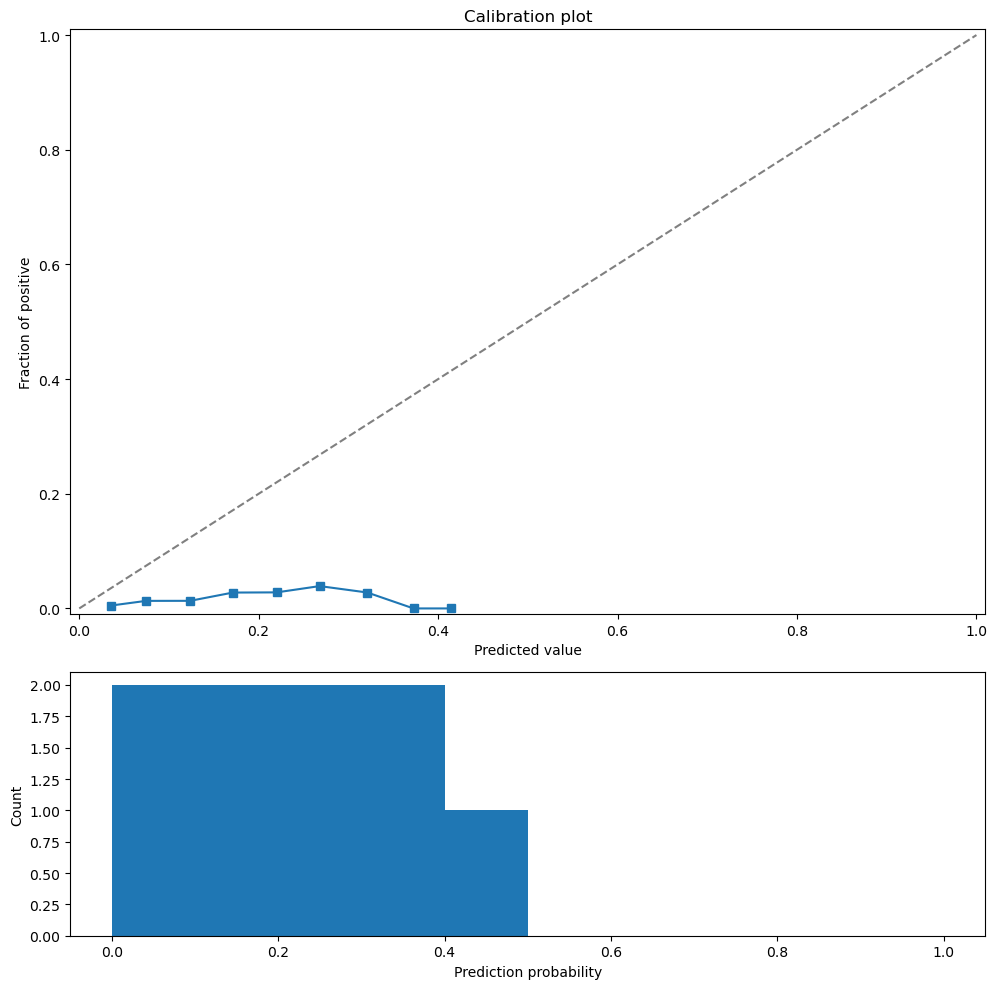

In [271]:
plotter(p2, y2)

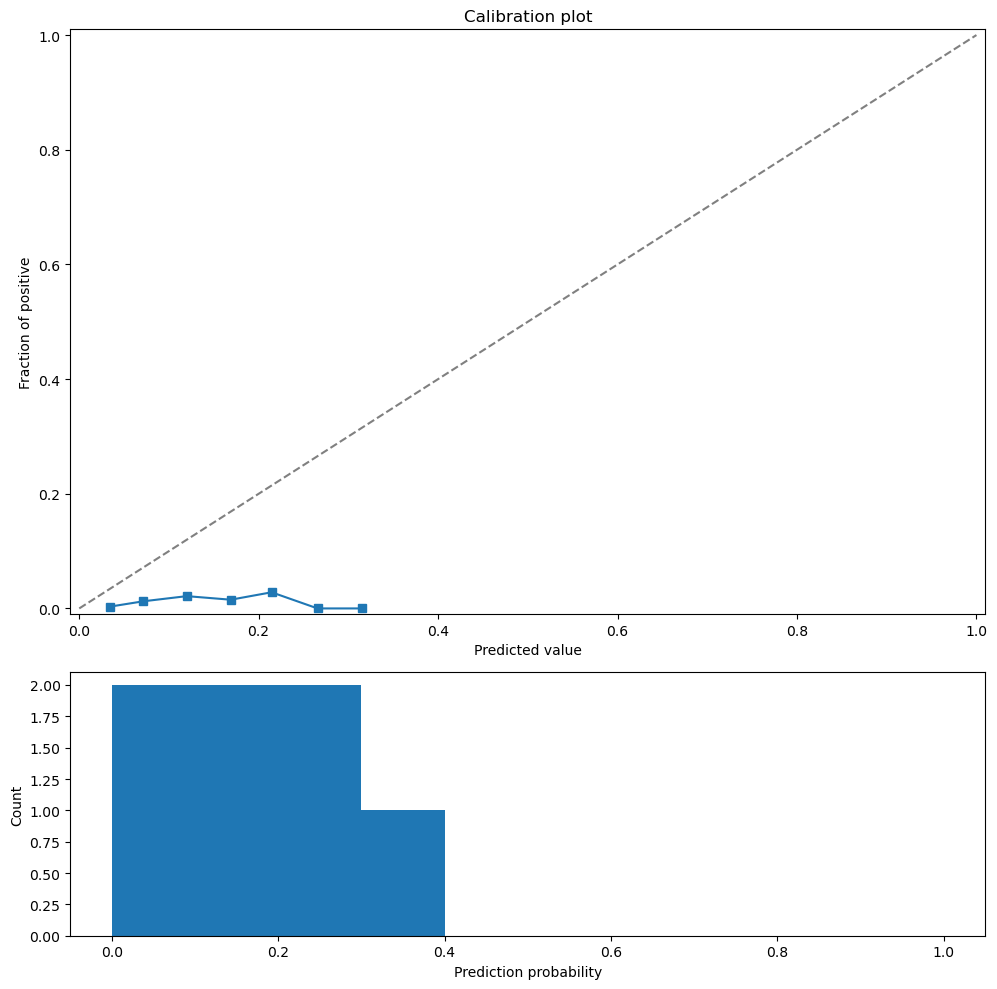

In [272]:
plotter(p3, y3)

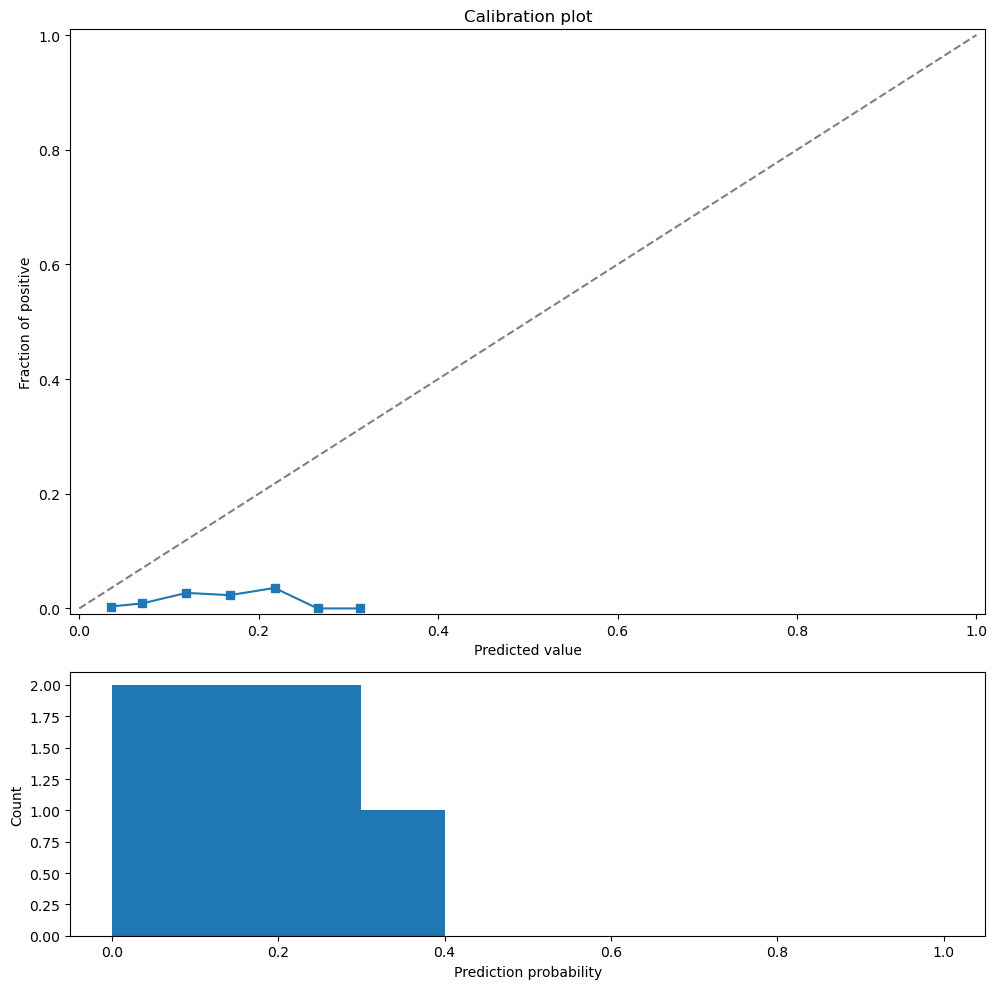

In [273]:
plotter(p4, y4)

(array([2451., 2792., 2698., 2569., 2145., 1737., 1021.,  459.,  146.,
          11.]),
 array([0.01589061, 0.06250444, 0.10911827, 0.1557321 , 0.20234593,
        0.24895976, 0.29557359, 0.34218742, 0.38880124, 0.43541507,
        0.4820289 ]),
 <BarContainer object of 10 artists>)

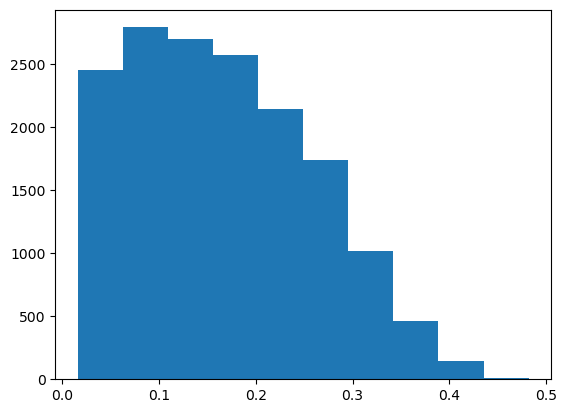

In [53]:
plt.hist( M1['probs'].to_numpy())

In [ ]:
sklearn.metrics.roc_auc_score(m1['outcome'],  m1['p6'], average = 'samples')


0.5600783435183764

In [ ]:
( confusion_matrix (m1['outcome'],  m1['p6']>.5) )

array([[72681,     5],
       [ 4301,     0]], dtype=int64)

In [ ]:
# how many people had event within 6 months of index date

In [27]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 

In [39]:
y1 = np.array(M1['golds'],dtype = int)
x1 = M1['probs'].to_numpy()
platt.fit(x1, y1)
cal_1 = platt.predict(M_test1['probs'])